# Machine Learning Foundation

## Course 3, Part d: Decision Tree LAB


## Introduction

We will be using the wine quality data set for these exercises. This data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is `Wine_Quality_Data.csv`.


In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

## Question 1

* Import the data and examine the features.
* We will be using all of them to predict `color` (white or red), but the colors feature will need to be integer encoded.


In [2]:
### BEGIN SOLUTION
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Wine_Quality_Data.csv", sep=',')

In [3]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [4]:
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

Convert the color feature to an integer. This is a quick way to do it using Pandas.


In [5]:
data['color'] = data.color.replace('white',0).replace('red',1).astype(np.int)
### END SOLUTION

## Question 2

* Use `StratifiedShuffleSplit` to split data into train and test sets that are stratified by wine quality. If possible, preserve the indices of the split for question 5 below.
* Check the percent composition of each quality level for both the train and test data sets.


In [6]:
### BEGIN SOLUTION
# All data columns except for color
feature_cols = [x for x in data.columns if x not in 'color']

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split the data into two parts with 1000 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['color']))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'color']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'color']

Now check the percent composition of each quality level in the train and test data sets. The data set is mostly white wine, as can be seen below.


In [8]:
y_train.value_counts(normalize=True).sort_index()

0    0.753866
1    0.246134
Name: color, dtype: float64

In [9]:
y_test.value_counts(normalize=True).sort_index()
### END SOLUTION

0    0.754
1    0.246
Name: color, dtype: float64

## Question 3

* Fit a decision tree classifier with no set limits on maximum depth, features, or leaves.
* Determine how many nodes are present and what the depth of this (very large) tree is.
* Using this tree, measure the prediction error in the train and test data sets. What do you think is going on here based on the differences in prediction error?


In [10]:
### BEGIN SOLUTION
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

The number of nodes and the maximum actual depth.


In [11]:
dt.tree_.node_count, dt.tree_.max_depth

(171, 22)

A function to return error metrics.


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

The decision tree predicts a little better on the training data than the test data, which is consistent with (mild)  overfitting. Also notice the perfect recall score for the training data. In many instances, this prediction difference is even greater than that seen here. 


In [13]:
# The error on the training and test data sets
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error
### END SOLUTION

,train,test
accuracy,0.999818,0.984000
precision,0.999261,0.963710
recall,1.000000,0.971545
f1,0.999631,0.967611


## Question 4

* Using grid search with cross validation, find a decision tree that performs well on the test data set. Use a different variable name for this decision tree model than in question 3 so that both can be used in question 6.
* Determine the number of nodes and the depth of this tree.
* Measure the errors on the training and test sets as before and compare them to those from the tree in question 3.


In [14]:
### BEGIN SOLUTION
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

The number of nodes and the maximum depth of the tree.


In [15]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(99, 7)

These test errors are a little better than the previous ones. So it would seem the previous example overfit the data, but only slightly so.


In [16]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)

In [17]:
train_test_gr_error
### END SOLUTION

,train,test
accuracy,0.995816,0.989000
precision,0.998501,0.983539
recall,0.984479,0.971545
f1,0.991440,0.977505


## Question 5

* Re-split the data into `X` and `y` parts, this time with `residual_sugar` being the predicted (`y`) data. *Note:* if the indices were preserved from the `StratifiedShuffleSplit` output in question 2, they can be used again to split the data.
* Using grid search with cross validation, find a decision tree **regression** model that performs well on the test data set.
* Measure the errors on the training and test sets using mean squared error.
* Make a plot of actual *vs* predicted residual sugar.


In [18]:
### BEGIN SOLUTION
feature_cols = [x for x in data.columns if x != 'residual_sugar']

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'residual_sugar']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'residual_sugar']

In [19]:
from sklearn.tree import DecisionTreeRegressor

dr = DecisionTreeRegressor().fit(X_train, y_train)

param_grid = {'max_depth':range(1, dr.tree_.max_depth+1, 2),
              'max_features': range(1, len(dr.feature_importances_)+1)}

GR_sugar = GridSearchCV(DecisionTreeRegressor(random_state=42),
                     param_grid=param_grid,
                     scoring='neg_mean_squared_error',
                      n_jobs=-1)

GR_sugar = GR_sugar.fit(X_train, y_train)

The number of nodes and the maximum depth of the tree. This tree has lots of nodes, which is not so surprising given the continuous data.


In [20]:
GR_sugar.best_estimator_.tree_.node_count, GR_sugar.best_estimator_.tree_.max_depth

(7953, 25)

The error on train and test data sets. Since this is continuous, we will use mean squared error.


In [21]:
from sklearn.metrics import mean_squared_error

y_train_pred_gr_sugar = GR_sugar.predict(X_train)
y_test_pred_gr_sugar  = GR_sugar.predict(X_test)

train_test_gr_sugar_error = pd.Series({'train': mean_squared_error(y_train, y_train_pred_gr_sugar),
                                         'test':  mean_squared_error(y_test, y_test_pred_gr_sugar)},
                                          name='MSE').to_frame().T

train_test_gr_sugar_error

,train,test
MSE,0.00055,2.659874


A plot of actual vs predicted residual sugar.


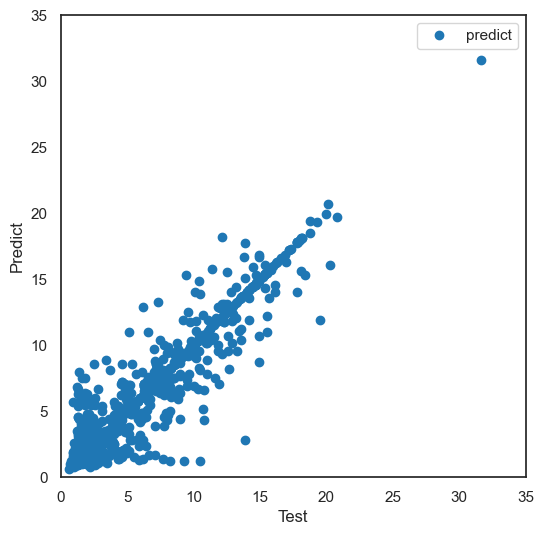

In [22]:
sns.set_context('notebook')
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ph_test_predict = pd.DataFrame({'test':y_test.values,
                                'predict': y_test_pred_gr_sugar}).set_index('test').sort_index()

ph_test_predict.plot(marker='o', ls='', ax=ax)
ax.set(xlabel='Test', ylabel='Predict', xlim=(0,35), ylim=(0,35));
### END SOLUTION

## Question 6 

This question requires an additional command line program (GraphViz) and Python library (PyDotPlus). GraphViz can be installed with a package manager on Linux and Mac. For PyDotPlus, either `pip` or `conda` (`conda install -c conda-forge pydotplus`) can be used to install the library.

Once these programs are installed:

* Create a visualization of the decision tree from question 3, where wine color was predicted and the number of features and/or splits are not limited.
* Create a visualization of the decision tree from question 4, where wine color was predicted but a grid search was used to find the optimal depth and number of features.

The decision tree from question 5 will likely have too many nodes to visualize.


In [25]:
conda install -c conda-forge pydotplus

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\hp\anaconda3

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.5.7   |       h56e8100_0         145 KB  conda-forge
    cairo-1.16.0               |    h63a05c6_1001         5.2 MB  conda-forge
    certifi-2023.5.7           |     pyhd8ed1ab_0         149 KB  conda-forge
    conda-22.11.1              |   py39hcbf5309_1         908 KB  conda-forge
    conda-build-3.21.9         |   py39hcbf5309_1         578 KB  conda-forge
    expat-2.5.0                |       h63175ca_1         221 KB  conda-forge
    flask-2.2.3                |     pyhd8ed1ab_0          81 KB  conda-forge
    fribidi-1.0.10             |       h8d14728_0          63 KB  conda-forge
    getopt-win32-0.1           |       h8f


The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::anaconda==2022.10=py310_0
  - defaults/win-64::anaconda-project==0.11.1=py39haa95532_0
  - defaults/win-64::bcrypt==3.2.0=py39h2bbff1b_1
  - defaults/win-64::bokeh==2.4.3=py39haa95532_0
  - defaults/win-64::conda-build==3.22.0=py39haa95532_0
  - defaults/noarch::conda-verify==3.4.2=py_1
  - defaults/noarch::cookiecutter==1.7.3=pyhd3eb1b0_0
  - defaults/win-64::dask==2022.7.0=py39haa95532_0
  - defaults/win-64::datashader==0.14.1=py39haa95532_0
  - defaults/win-64::distributed==2022.7.0=py39haa95532_0
  - defaults/win-64::gensim==4.1.2=py39hd77b12b_0
  - defaults/win-64::holoviews==1.15.0=py39haa95532_0
  - defaults/win-64::hvplot==0.8.0=py39haa95532_0
  - defaults/noarch::intake==0.6.5=pyhd3eb1b0_0
  - defaults/noarch::ipywidgets==7.6.5=pyhd3eb1b0_1
  - defaults/noarch::jinja2-time==0.2.0=pyhd3eb1b0_3
  - defaults/win-64::jupyter==1.0.0=p

In [26]:
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

The tree from question 3.


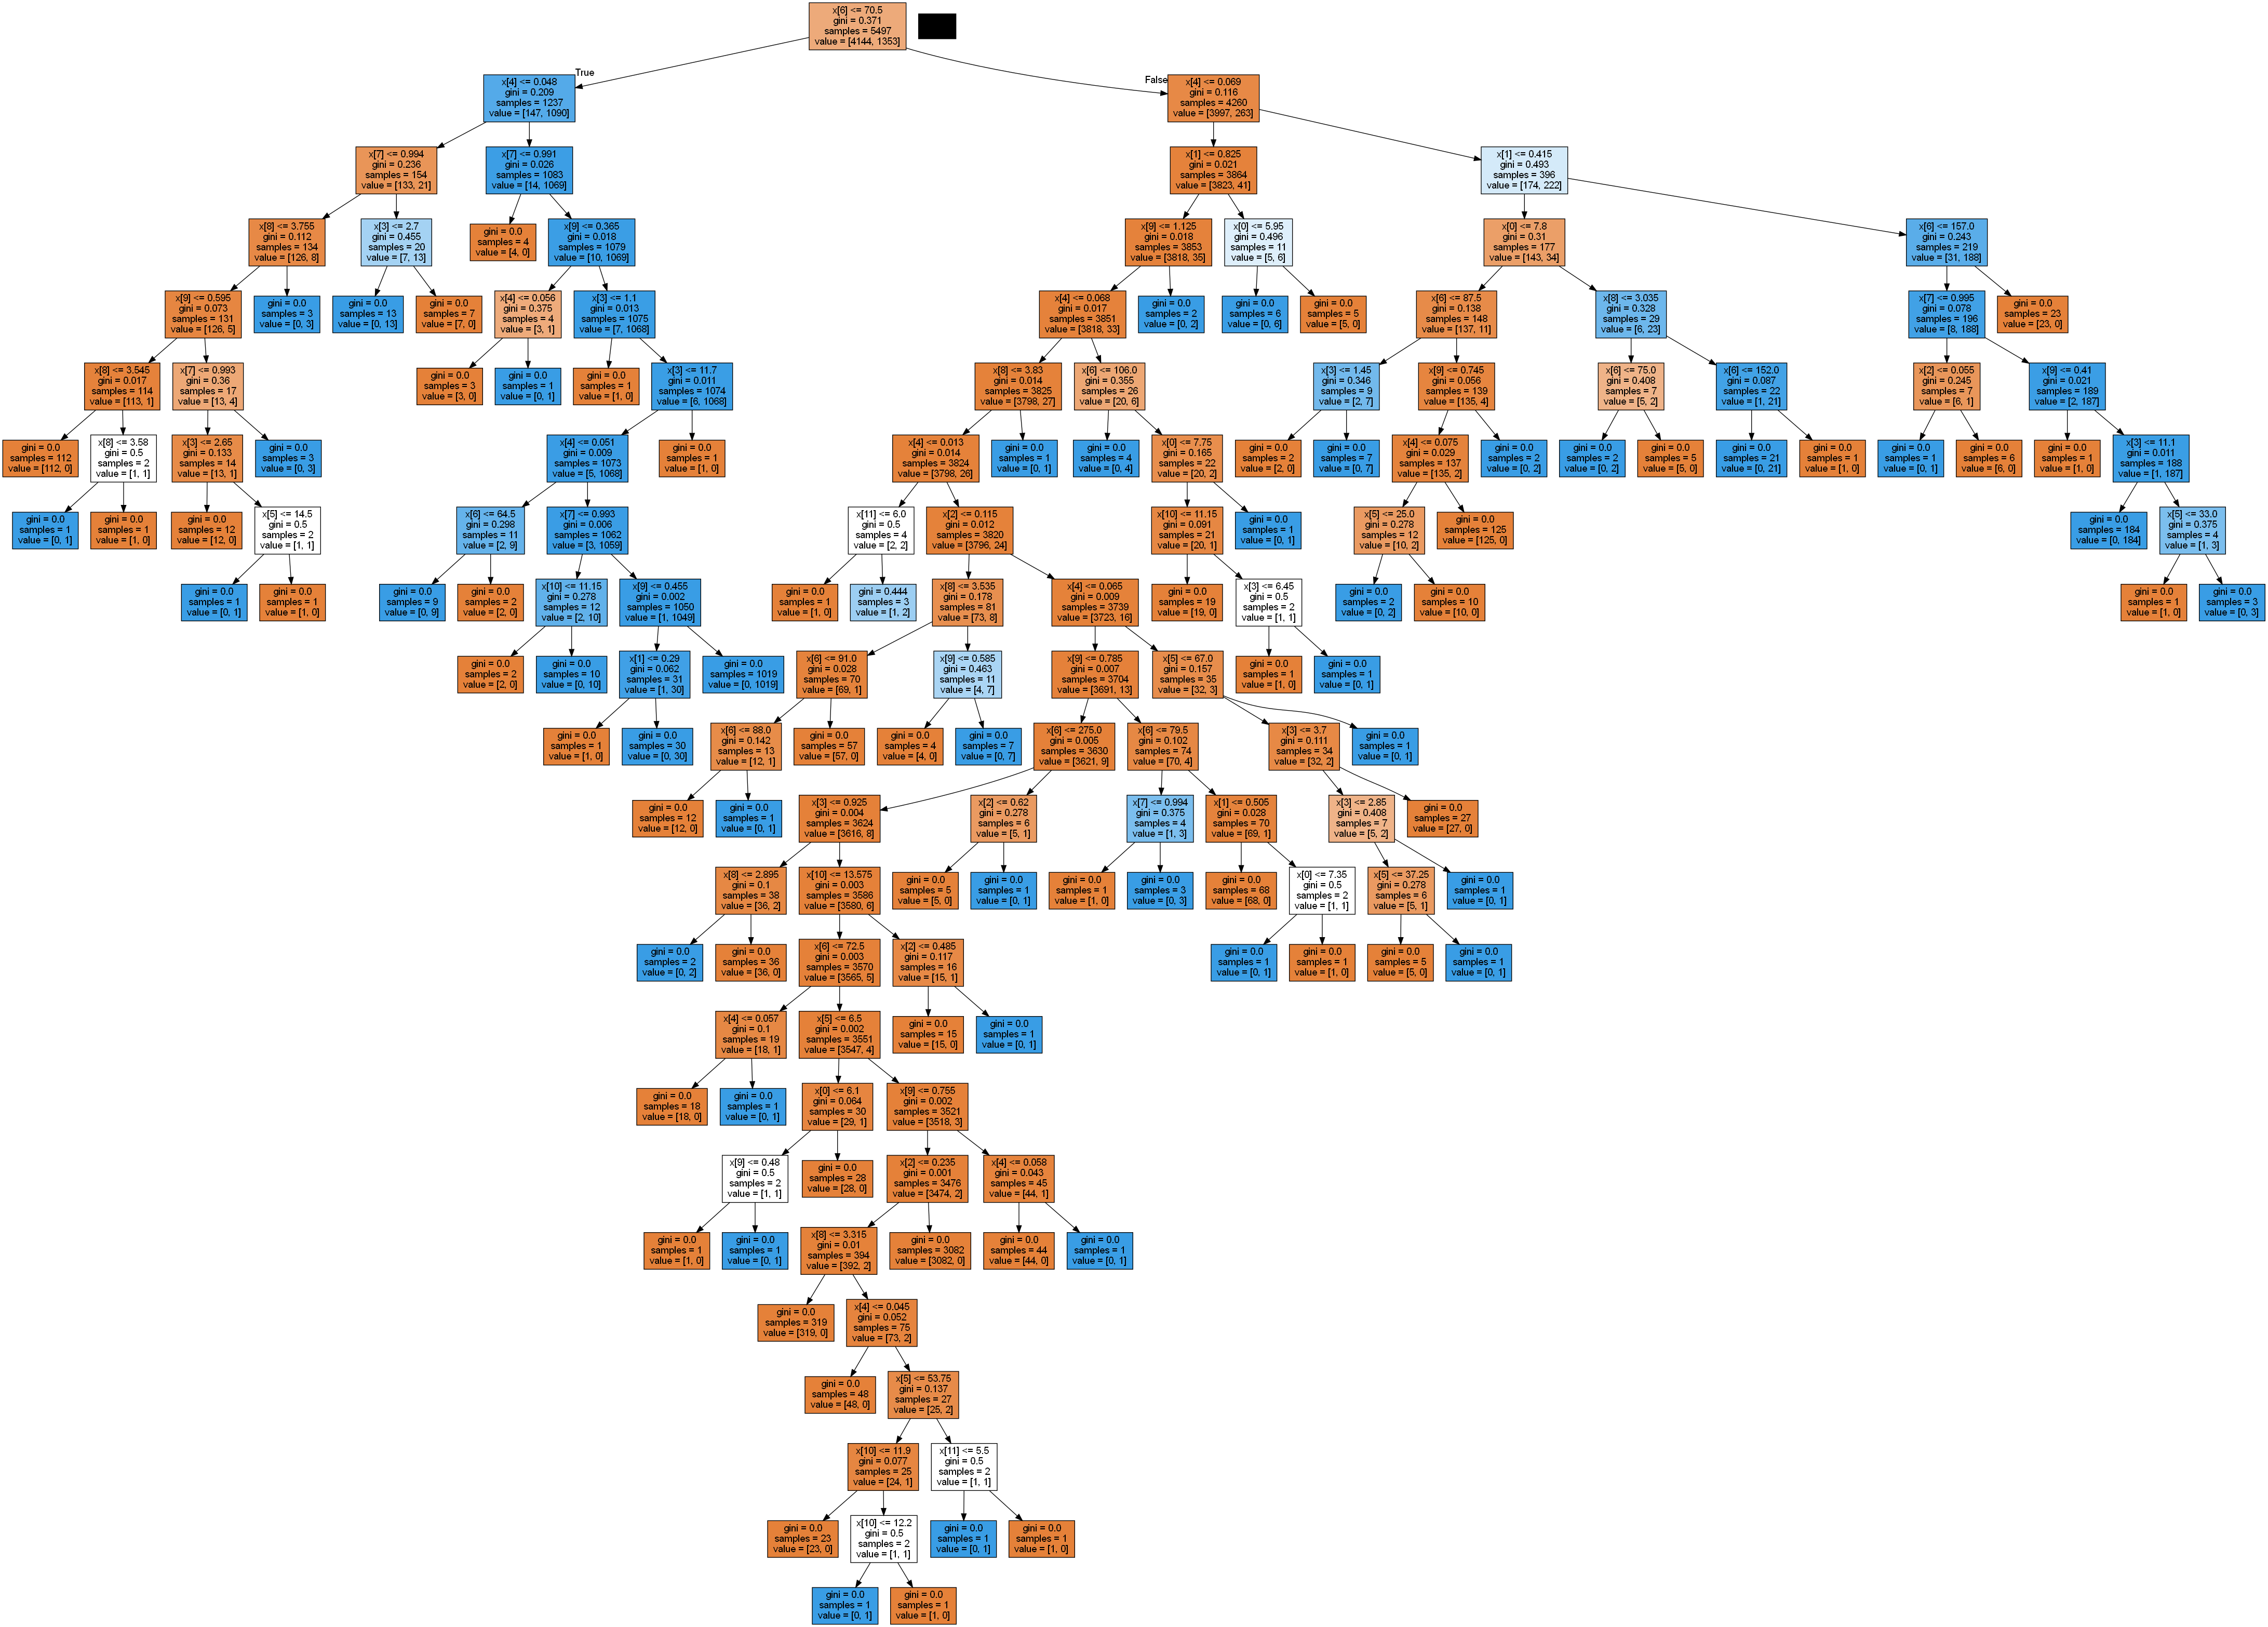

In [27]:
### BEGIN SOLUTION
# Create an output destination for the file
dot_data = StringIO()

export_graphviz(dt, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# View the tree image
filename = 'wine_tree.png'
graph.write_png(filename)
Image(filename=filename) 

The tree fit with cross validation from question 4. This tree is much shallower than the previous one.


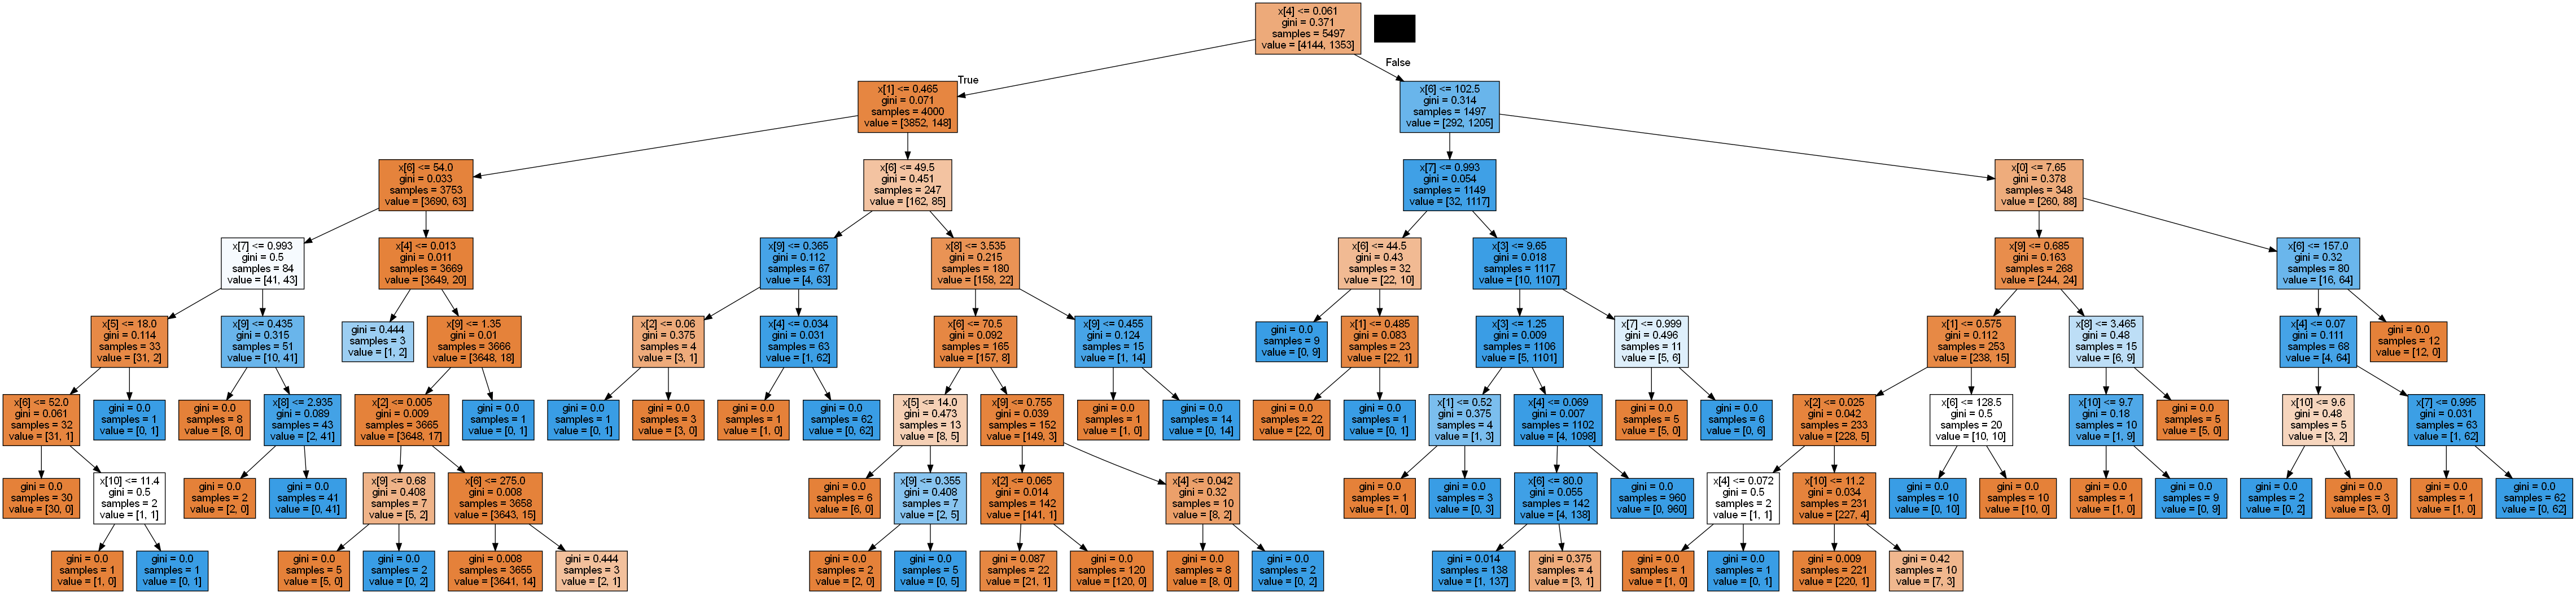

In [28]:
# Create an output destination for the file
dot_data = StringIO()

export_graphviz(GR.best_estimator_, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# View the tree image
filename = 'wine_tree_prune.png'
graph.write_png(filename)
Image(filename=filename) 
### END SOLUTION

---
### Machine Learning Foundation (C) 2020 IBM Corporation
